Manel Azoun 84966753\
Emma Gjøen 74324823\
Srijan Ravisankar 86992831\
Thayantha Sritharan 38664397

# Data Science Project - Final Report

## Introduction
A UBC research group studies player behaviours in video games and does so by operating a Minecraft server where player activity is recorded to understand engagement and contribution patterns. Minecraft is like a creative playground where one can explore, build, and have adventures in a virtual world without set rules or goals, making it a versatile platform for studying player behaviour. The research group wants to manage its server resources according to the demands, and they want to recruit more players to collect data on. In order to recruit more players, the stakeholder wants to know which “kinds” of players are most likely to contribute a large amount of data, so that they can be targeted in the recruiting efforts. In this report, we plan to help with this by the analysis of the following question below.

---

#### Question

*Which types of players, based on experience, age, and gender, are most likely to contribute substantial data (playing one hour or more)?* The response variable is `contributor` (which will be created after data wrangling), and the explanatory variables are `experience`, `age`, and `gender` and `start_day`. Identifying and predicting contributors in the data will help the research group focus its recruitment efforts on players most likely to provide valuable data.

---

### Data Description
We were given two datasets: "Players" and "Sessions". The Players dataset has one row for each individual player. The Sessions dataset has one row for each played session. Due to the choice of explanatory and response variables in our question, we only need to use the Players dataset.

Players Dataset: `players_data` contains demographic information of each player, collected when the players register for the Minecraft server.
- Observations: 196 
- Variables: 9

In [64]:
#Load necessary libraries
library(tidyverse)
library(dplyr) 
library(ggplot2) 
library(repr)
library(tidymodels)
library(patchwork) #to display some plots next to each other

In [65]:
#Coded table describing the variables (not included in the word limit)

players_variable_summary <- tibble(Variable_name = c("experience", "suscribe", "hashedEmail",
                                        "played_hours",	"name",	"gender", "age", "individualId", "organizationName"), 
                           Variable_description = c("Player’s Minecraft experience", "Whether the player is subscribed for server emails", 
                                                    "Encrypted players’ email for anonymity", "Hours the player has spent on the server", 
                                                    "Player’s in-name game", "Player’s gender", "Player’s age", "Identifier of the player",
                                                    "Organization of the player"),
                           Variable_type = c("Categorical (character)", "Logical", "Categorical (character)", "Numerical", "Categorical (character)", 
                                             "Categorical (character)", "Numerical", "Logical", "Logical")) 
players_variable_summary

Variable_name    Variable_description                              
1 experience       Player’s Minecraft experience                     
2 suscribe         Whether the player is subscribed for server emails
3 hashedEmail      Encrypted players’ email for anonymity            
4 played_hours     Hours the player has spent on the server          
5 name             Player’s in-name game                             
6 gender           Player’s gender                                   
7 age              Player’s age                                      
8 individualId     Identifier of the player                          
9 organizationName Organization of the player                        
  Variable_type          
1 Categorical (character)
2 Logical                
3 Categorical (character)
4 Numerical              
5 Categorical (character)
6 Categorical (character)
7 Numerical              
8 Logical                
9 Logical

#### Why is 1 hour chosen as the cutoff?

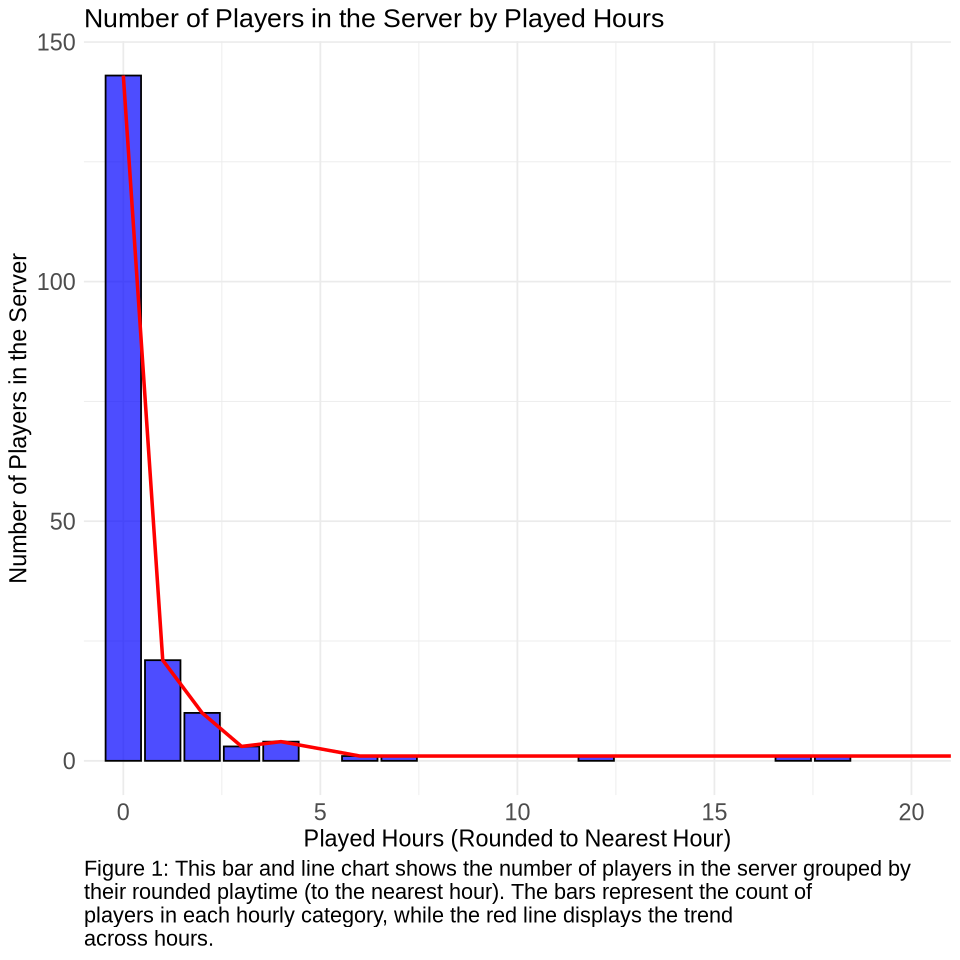

In [86]:
hourly_data <- players_data |>
  mutate(rounded_hours = round(played_hours)) |>
  group_by(rounded_hours) |>
  summarise(number_of_players = n())

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(hourly_data, aes(x = rounded_hours, y = number_of_players)) +
  geom_bar(stat = "identity", fill = "blue", color = "black", alpha = 0.7) +
  geom_line(aes(x = rounded_hours, y = number_of_players), color = "red", size = 1) + 
  labs(title = "Number of Players in the Server by Played Hours",
       x = "Played Hours (Rounded to Nearest Hour)",
       y = "Number of Players in the Server",
       caption = "Figure 1: This bar and line chart shows the number of players in the server grouped by 
their rounded playtime (to the nearest hour). The bars represent the count of 
players in each hourly category, while the red line displays the trend 
across hours.") +
  coord_cartesian(xlim = c(0, 20)) +
  theme_minimal() +
  theme(plot.title = element_text(size = 16),
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 14),
        plot.caption = element_text(hjust = 0, size = 13))

From the graph, we observe that the majority of players have played for less than one hour.  We note that the frequency drops sharply after 1 hour, indicating a distinct shift in players' behaviour or engagement.  We can infer that players who exceed this threshold are likely to be more committed or regular users, contributing more substantially to the data. This cutoff helps to create logical and interpretable groups, such as contributors and non-contributors, for analysis or intervention. Therefore, the choice of a 1-hour cutoff to define a contribution is grounded in this clear distribution pattern. 

## Methods & Results

The analysis begins with loading the dataset, which is hosted on a publicly available GitHub repository. Using the `read_csv()` function, the dataset is read into R. Unnecessary columns (individualId and organizationName) are excluded immediately using the select() function, as these are not pertinent to the analysis. 

In [67]:
#Displaying the data for data analysis
#Load the data sets 
players_url <- "https://raw.githubusercontent.com/EmmaGjoen/data_science_group_project/refs/heads/main/players.csv"
players_data <- read_csv(players_url)

#Select only relevant columns in players_data
players_data <- players_data |>
                select(-individualId, -organizationName)

head(players_data)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience subscribe
1 Pro         TRUE    
2 Veteran     TRUE    
3 Veteran    FALSE    
4 Amateur     TRUE    
5 Regular     TRUE    
6 Amateur     TRUE    
  hashedEmail                                                      played_hours
1 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
2 f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9  3.8        
3 b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28  0.0        
4 23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5  0.7        
5 7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e  0.1        
6 f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977  0.0        
  name      gender age
1 Morgan    Male    9 
2 Christian Male   17 
3 Blake     Male   17 
4 Flora     Female 21 
5 Kylie     Male   21 
6 Adrian    Female 17

Key variables required for the analysis— `experience`, `gender`, and `age`—are selected when wrangling the data. The variable `contributor` is derived from the condition where players with played_hours >= 1 are marked as contributors. Data types are adjusted appropriately: `experience` and `gender` are converted to factors for categorical treatment, and `age` is cast as an integer for consistency. Maintaining a tidy format ensures clarity, with each row representing a single player and their attributes. 

In [68]:
# Wrangling data 
wrangled_players_data <- players_data |>
  mutate(
    contributor = factor(if_else(played_hours >= 1, "Yes", "No")),
    experience = as.factor(experience),
    gender = as.factor(gender),
    age = as.integer(age),
  ) |>
  select(experience, gender, age, contributor)

head(wrangled_players_data)

experience gender age contributor
1 Pro        Male    9  Yes        
2 Veteran    Male   17  Yes        
3 Veteran    Male   17  No         
4 Amateur    Female 21  No         
5 Regular    Male   21  No         
6 Amateur    Female 17  No

Exploratory data analysis begins with generating summaries for key variables. Distribution summaries for experience and gender provide a count of players in each category, offering insight into the dataset’s categorical spread. For age, measures like min, max, mean, and median are computed to understand its numerical range. To identify potential trends, the age distribution is summarized into a grouped count for the six most frequent values. Proportions of contributors versus non-contributors are calculated to evaluate the dataset’s balance. These insights guide further analysis and ensure an informed understanding of the dataset.

In [69]:
#Summarizing data
#Counts of players by exprience
experience_distirbution <- wrangled_players_data |>
                              group_by(experience) |>
                              summarise(count = n())
experience_distirbution

#Counts of players by gender
gender_distribution <- wrangled_players_data|>
                          count(gender) 
gender_distribution

#Demograo
#Demographics of players by age
age_demo <- wrangled_players_data |>
                      summarise(
                        min_age = min(age),
                        max_age = max(age),
                        mean_age = mean(age),
                        median_age = median(age)
                      )
age_demo

#Counts of players by ages
age_distribution <- wrangled_players_data |>
                        group_by(age) |>
                        summarise(count = n()) |>
                        slice_max(count, n = 6)
age_distribution

#Proportion of contributors vs. non-contributors in the server
contributor_prop <- wrangled_players_data |>
                          count(contributor) |>
                          mutate(proportion = n / sum(n))
contributor_prop

experience count
1 Amateur    63   
2 Beginner   35   
3 Pro        14   
4 Regular    36   
5 Veteran    48

gender            n  
1 Agender             2
2 Female             37
3 Male              124
4 Non-binary         15
5 Other               1
6 Prefer not to say  11
7 Two-Spirited        6

min_age max_age mean_age median_age
1 8       99      21.28061 19

age count
1 17  75   
2 21  18   
3 22  15   
4 20  14   
5 23  13   
6 24  10

contributor n   proportion
1 No          154 0.7857143 
2 Yes          42 0.2142857

Visualization enhances comprehension of data patterns. Bar plots are used to display contributor status distribution across levels of experience and gender. These visualizations reveal trends, such as potential correlations between experience and contributor status. A box plot with jitter for age distribution highlights the range and median age differences between contributors and non-contributors. 

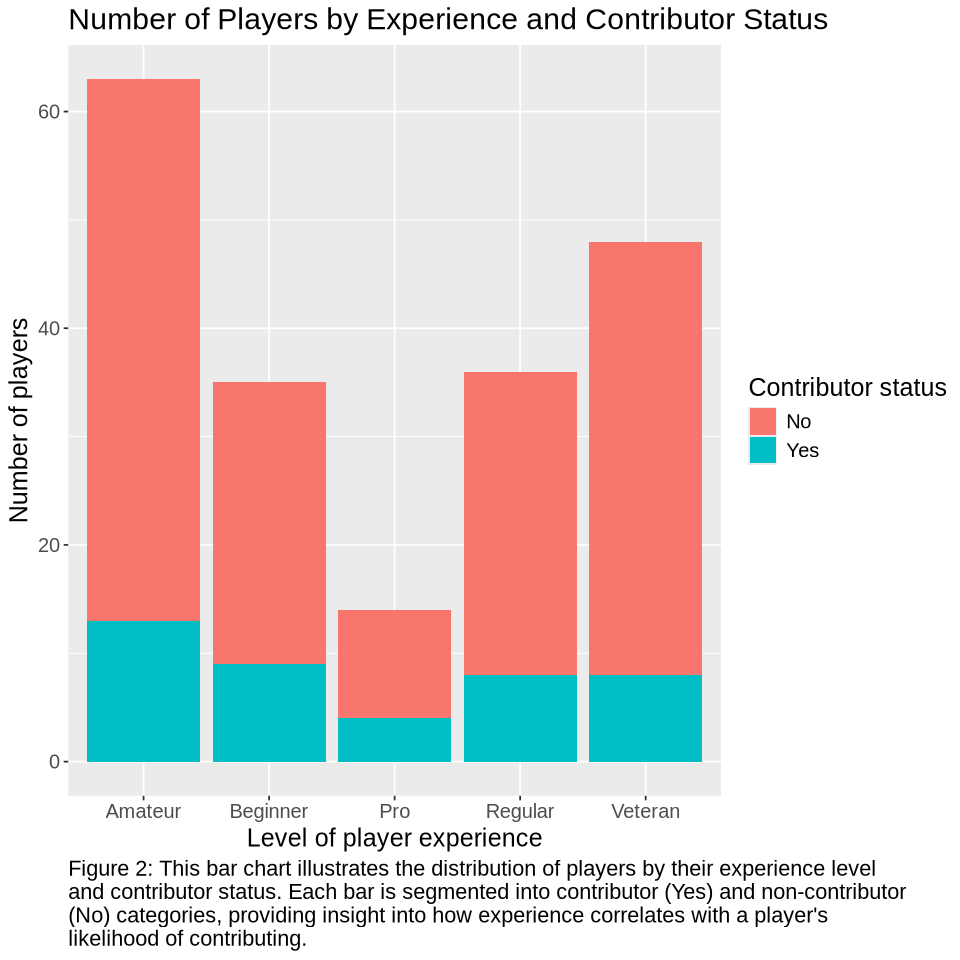

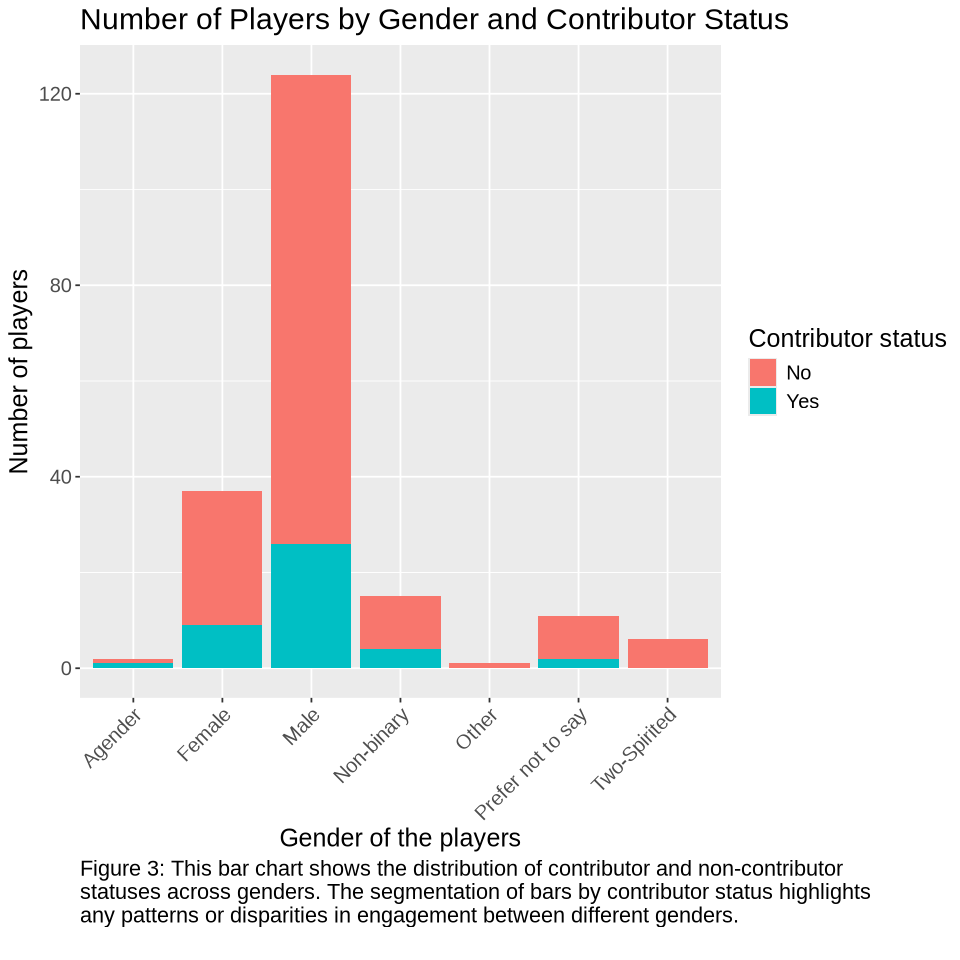

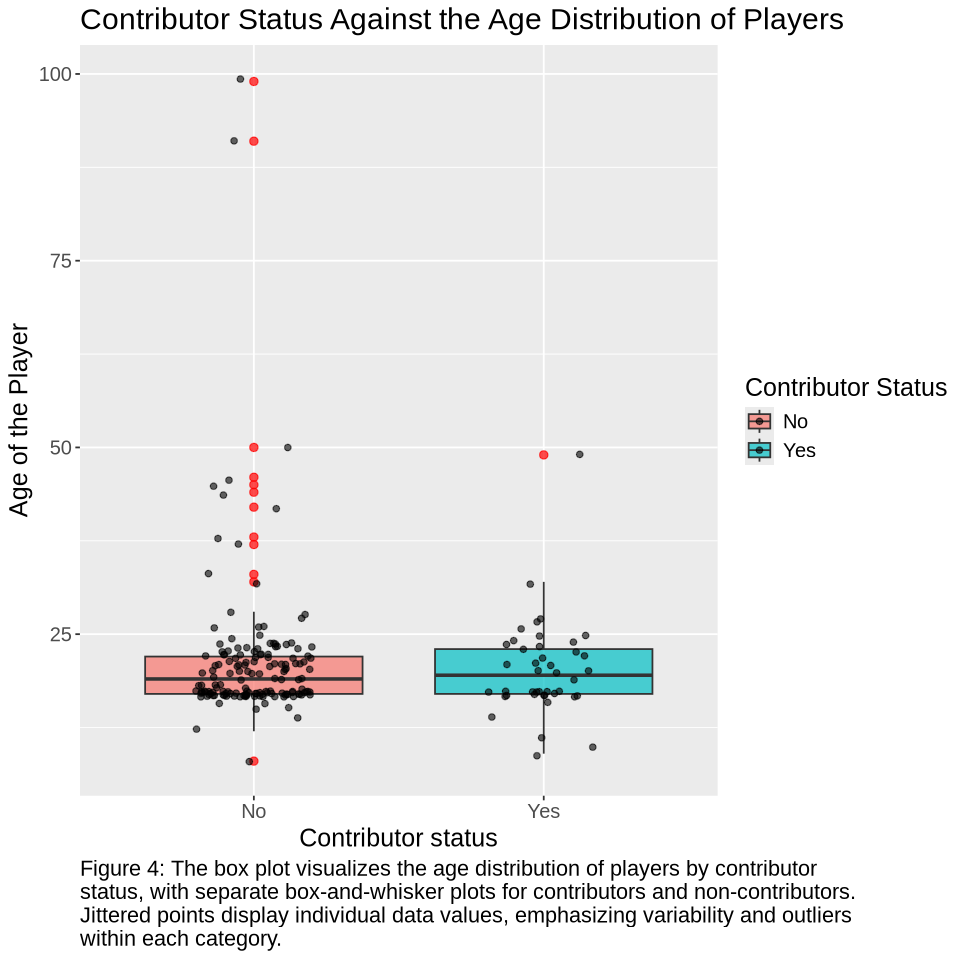

In [87]:
# Visualizing data
#Plot dimensions
options(repr.plot.height = 8, repr.plot.width = 8)

#Bar graph to decipher players' contributor status based on their experience
experience_plot <- ggplot(wrangled_players_data, aes(x = experience, fill = factor(contributor))) +
                        geom_bar(position = "stack") +
                        labs(
                            title = "Number of Players by Experience and Contributor Status",
                            x = "Level of player experience",
                            y = "Number of players",
                            fill = "Contributor status",
                            caption = "Figure 2: This bar chart illustrates the distribution of players by their experience level 
and contributor status. Each bar is segmented into contributor (Yes) and non-contributor 
(No) categories, providing insight into how experience correlates with a player's 
likelihood of contributing."
                            ) + 
                        theme(text = element_text(size = 15), 
                              plot.caption = element_text(hjust = 0, size = 13))
experience_plot

#Bar graph to show propotion of contribuots and non-contributors across players' gender
#experience_proportion_plot <- ggplot(wrangled_players_data, aes(x = experience, fill = factor(contributor))) +
#                        geom_bar(position = "fill") +
#                        labs(
#                            title = "Proportion of contributors by players' experience",
#                            x = "Level of experience",
#                            y = "Proportion of contributors to non-contributors \n(of the total amount of players)",
#                            fill = "Contributor",
#                            caption = "Figure 3: This bar chart represents the proportion of contributors and non-contributors 
#within each experience level. The chart divides each bar into segments that 
#indicate the relative share of contributors (Yes) and non-contributors (No) 
#for every experience category."
#                            ) + 
#                        theme(text = element_text(size = 15), 
#                              plot.caption = element_text(hjust = 0, size = 13))
#Display the predicted and true classes next to each other
#experience_plot | experience_proportion_plot

#Bar graph to decipher players' contributor status based on their gender
gender_plot <- ggplot(wrangled_players_data, aes(x = gender, fill = factor(contributor))) +
                    geom_bar(position = "stack") +
                    labs(
                        title = "Number of Players by Gender and Contributor Status",
                        x = "Gender of the players",
                        y = "Number of players",
                        fill = "Contributor status",
                        caption = "Figure 3: This bar chart shows the distribution of contributor and non-contributor 
statuses across genders. The segmentation of bars by contributor status highlights 
any patterns or disparities in engagement between different genders.
                        "
                    ) + 
                    theme(text = element_text(size = 15),
                          axis.text.x = element_text(angle = 45, hjust = 1), 
                          plot.caption = element_text(hjust = 0, size = 13))
gender_plot

#Bar graph to show propotion of contribuots and non-contributors across players' gender
#gender_proportion_plot <- ggplot(wrangled_players_data, aes(x = gender, fill = factor(contributor))) +
#                   geom_bar(position = "fill") +
#                    labs(
#                        title = "Proportion of contributors by players' gender",
#                        x = "Gender",
#                       y = "Proportion of contributors to non-contributors \n(of the total amount of players)",
#                        fill = "Contributor",
#                       caption = "Figure 5: This bar chart depicts the proportion of contributors and non-contributors 
#for each gender category. Each bar is segmented to show the share of contributors 
#(Yes) versus non-contributors (No), highlighting potential disparities in 
#engagement between genders."
 #                  ) + 
#                   theme(text = element_text(size = 15),
#                        axis.text.x = element_text(angle = 45, hjust = 1),
#                        plot.caption = element_text(hjust = 0, size = 13))
#Display the predicted and true classes next to each other
#gender_plot | gender_proportion_plot

#Plot dimensions
options(repr.plot.height = 8, repr.plot.width = 8)

#Box plot to decipher players' contributor status based on their age
age_plot <- ggplot(wrangled_players_data, aes(x = factor(contributor), y = age, fill = contributor)) +
                geom_boxplot(alpha = 0.7, outlier.size = 2, outlier.color = "red") +
                geom_jitter(width = 0.2, size = 1.5, alpha = 0.6, color = "black") +
                labs(
                    title = "Contributor Status Against the Age Distribution of Players",
                    x = "Contributor status",
                    y = "Age of the Player",
                    fill = "Contributor Status",
                    caption = "Figure 4: The box plot visualizes the age distribution of players by contributor 
status, with separate box-and-whisker plots for contributors and non-contributors. 
Jittered points display individual data values, emphasizing variability and outliers 
within each category."
                ) + 
                theme(text = element_text(size = 15), 
                     plot.caption = element_text(hjust = 0, size = 13))
age_plot

The classification problem is addressed using the K-Nearest Neighbors (KNN) algorithm. The dataset is split into training (75%) and testing (25%) sets. A recipe is made for the training model, with the `age` predictor is scaled and centred to standardize its ranges, due to it being a numerical variable, and `step_dummy` encoding categorical variables. The knn model is also made with the parameter `neighbour = tune()`, so the model can evaluate various k-values through cross-validation. 


A cross-validation approach with 5 folds is used to tune the number of neighbors (k), ensuring robust model evaluation. A grid of candidate k values is created, and accuracy is assessed for each. The optimal k value is selected based on the highest mean accuracy from cross-validation. This is visualized in a plot showing accuracy versus k, with the best value marked by a dashed line. 


The final KNN model is fitted using the optimal k and evaluated on the testing set. Metrics like accuracy, precision, and recall are calculated to assess the model’s performance. Additionally, a confusion matrix provides detailed insights into classification results.

In [88]:
# Setting seed at the start for reproducibility
set.seed(123)

#test_data <- players_data |>
#  mutate(
#    contributor = factor(if_else(played_hours >= 1, "Yes", "No")),
#    experience = as.factor(experience),
#    gender = as.factor(gender),
#    age = as.integer(age)
#  ) |>
#  select(experience, gender, age, contributor)
#test_data

# Splitting data into training and testing sets
players_split <- initial_split(wrangled_players_data, prop = 0.75, strata = contributor)
players_train <- training(players_split)
players_test <- testing(players_split)

#Creating recipe
players_recipe <- recipe(contributor ~ experience + gender + age, data = players_train) |>
                    step_scale(all_numeric_predictors()) |>
                    step_center(all_numeric_predictors()) |>
                    step_dummy(all_nominal_predictors())

#Defining KNN specification
players_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

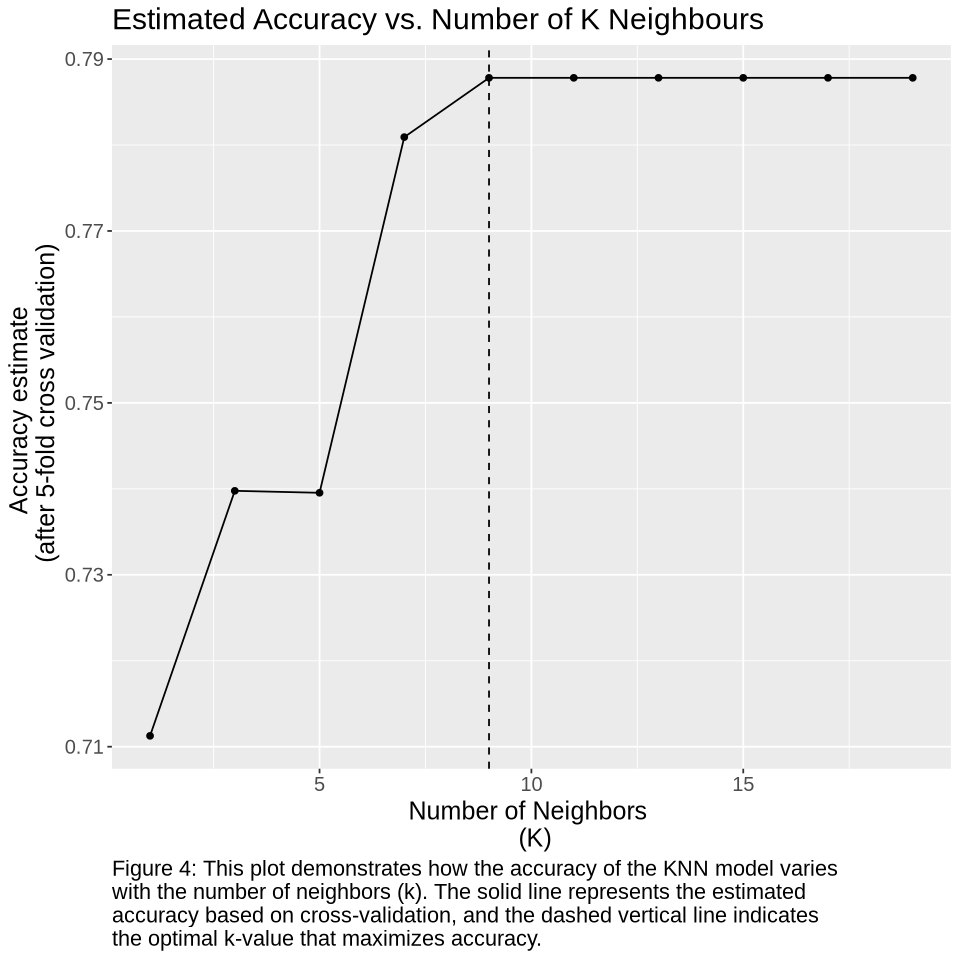

In [89]:
#Setting seed at the start for reproducibility
set.seed(123)

# 5-fold cross validation
players_folds <- vfold_cv(players_train, v = 5, strata = contributor)

#Grid
players_k_values <- tibble(neighbors = seq(from = 1, to = 20, by = 2))

#Tuning the model
players_knn_results <- workflow() |>
                        add_recipe(players_recipe) |>
                        add_model(players_knn_spec) |>
                        tune_grid(resamples = players_folds, grid = players_k_values) |>
                        collect_metrics()

#Extracting best k from results
accuracies <- players_knn_results |> 
                filter(.metric == "accuracy")

best_k <- accuracies |> 
            arrange(desc(mean)) |> 
            slice(1) |> 
            pull(neighbors)

#Plot accuracy vs k-value
options(repr.plot.height = 8, repr.plot.width = 8)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Number of Neighbors \n (K)",
                         y = "Accuracy estimate \n (after 5-fold cross validation)",
                         title = "Estimated Accuracy vs. Number of K Neighbours",
                        caption = "Figure 4: This plot demonstrates how the accuracy of the KNN model varies 
with the number of neighbors (k). The solid line represents the estimated 
accuracy based on cross-validation, and the dashed vertical line indicates
the optimal k-value that maximizes accuracy.") +
                    theme(text = element_text(size = 15),
                          plot.caption = element_text(hjust = 0, size = 13)) +  
                    geom_vline(xintercept = best_k, linetype = "dashed")
accuracy_vs_k

In [90]:
#Setting seed at the start for reproducibility
set.seed(123)

#Define KNN specification with best k
final_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

#Creating workflow with final specification
final_knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(final_knn_spec) |>
    fit(players_train)

#Making predictions on the testing data
test_predictions <- predict(final_knn_fit, new_data = players_test) |>
    bind_cols(players_test)

In [91]:
# Setting seed at the start for reproducibility
set.seed(123)

# Evaluating test metrics
test_results <- test_predictions |>
    mutate(correctness = if_else(contributor == .pred_class, "Correct", "Incorrect"))
cat("Final test result: \n")
head(test_results)

cat("\n")

test_accuracy <- test_results |>
  summarise(accuracy = mean(correctness == "Correct")) |>
  pull(accuracy)
cat("The accuracy of the test result is:", test_accuracy, "\n")
cat("Best k:", best_k, "\n")

# Calculating accuracy
accuracy_result <- test_predictions |>
  metrics(truth = contributor, estimate = .pred_class) |>
  filter(.metric == "accuracy")
cat("\nAccuracy:\n")
print(accuracy_result)

cat("\n")

# Calculating precision
precision_result <- test_predictions |>
  precision(truth = contributor, estimate = .pred_class)
cat("\nPrecision:\n")
print(precision_result)

cat("\n")

# Calculating recall
recall_result <- test_predictions |>
  recall(truth = contributor, estimate = .pred_class)
cat("\nRecall:\n")
print(recall_result)

cat("\n")

# Confusion matrix
confusion_matrix <- test_predictions |>
  conf_mat(truth = contributor, estimate = .pred_class)
cat("\nConfusion Matrix:\n")
print(confusion_matrix)

Final test result: 


.pred_class experience gender     age contributor correctness
1 No          Veteran    Male       17  No          Correct    
2 No          Amateur    Female     21  No          Correct    
3 No          Regular    Male       21  No          Correct    
4 No          Pro        Male       17  No          Correct    
5 No          Amateur    Male       22  No          Correct    
6 No          Veteran    Non-binary 17  No          Correct


The accuracy of the test result is: 0.74 
Best k: 9 

Accuracy:
# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary          0.74


Precision:
# A tibble: 1 × 3
  .metric   .estimator .estimate
  <chr>     <chr>          <dbl>
1 precision binary         0.771


Recall:
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 recall  binary         0.949


Confusion Matrix:
          Truth
Prediction No Yes
       No  37  11
       Yes  2   0


Comparative scatter plots illustrate the predicted versus true contributor classes based on combinations of age, experience, and gender.  These plots serve as the final validation of the analysis, offering a visual summary of model performance and alignment with true outcomes.

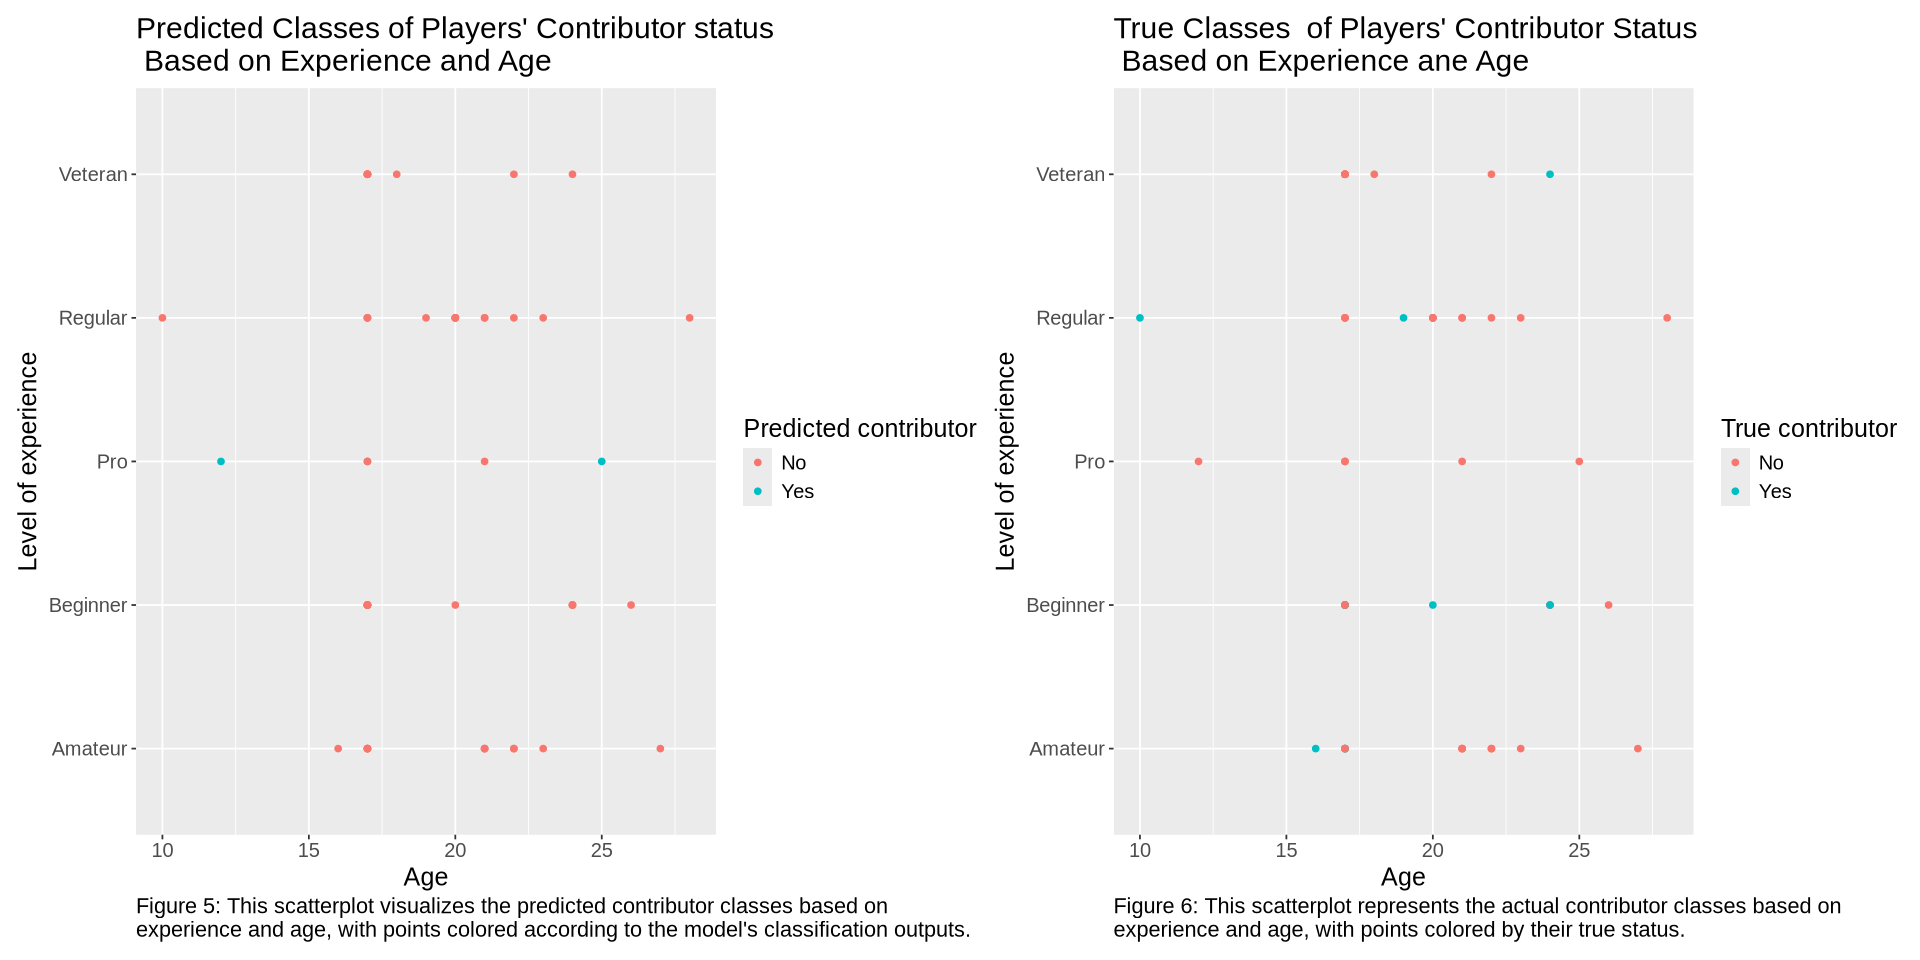

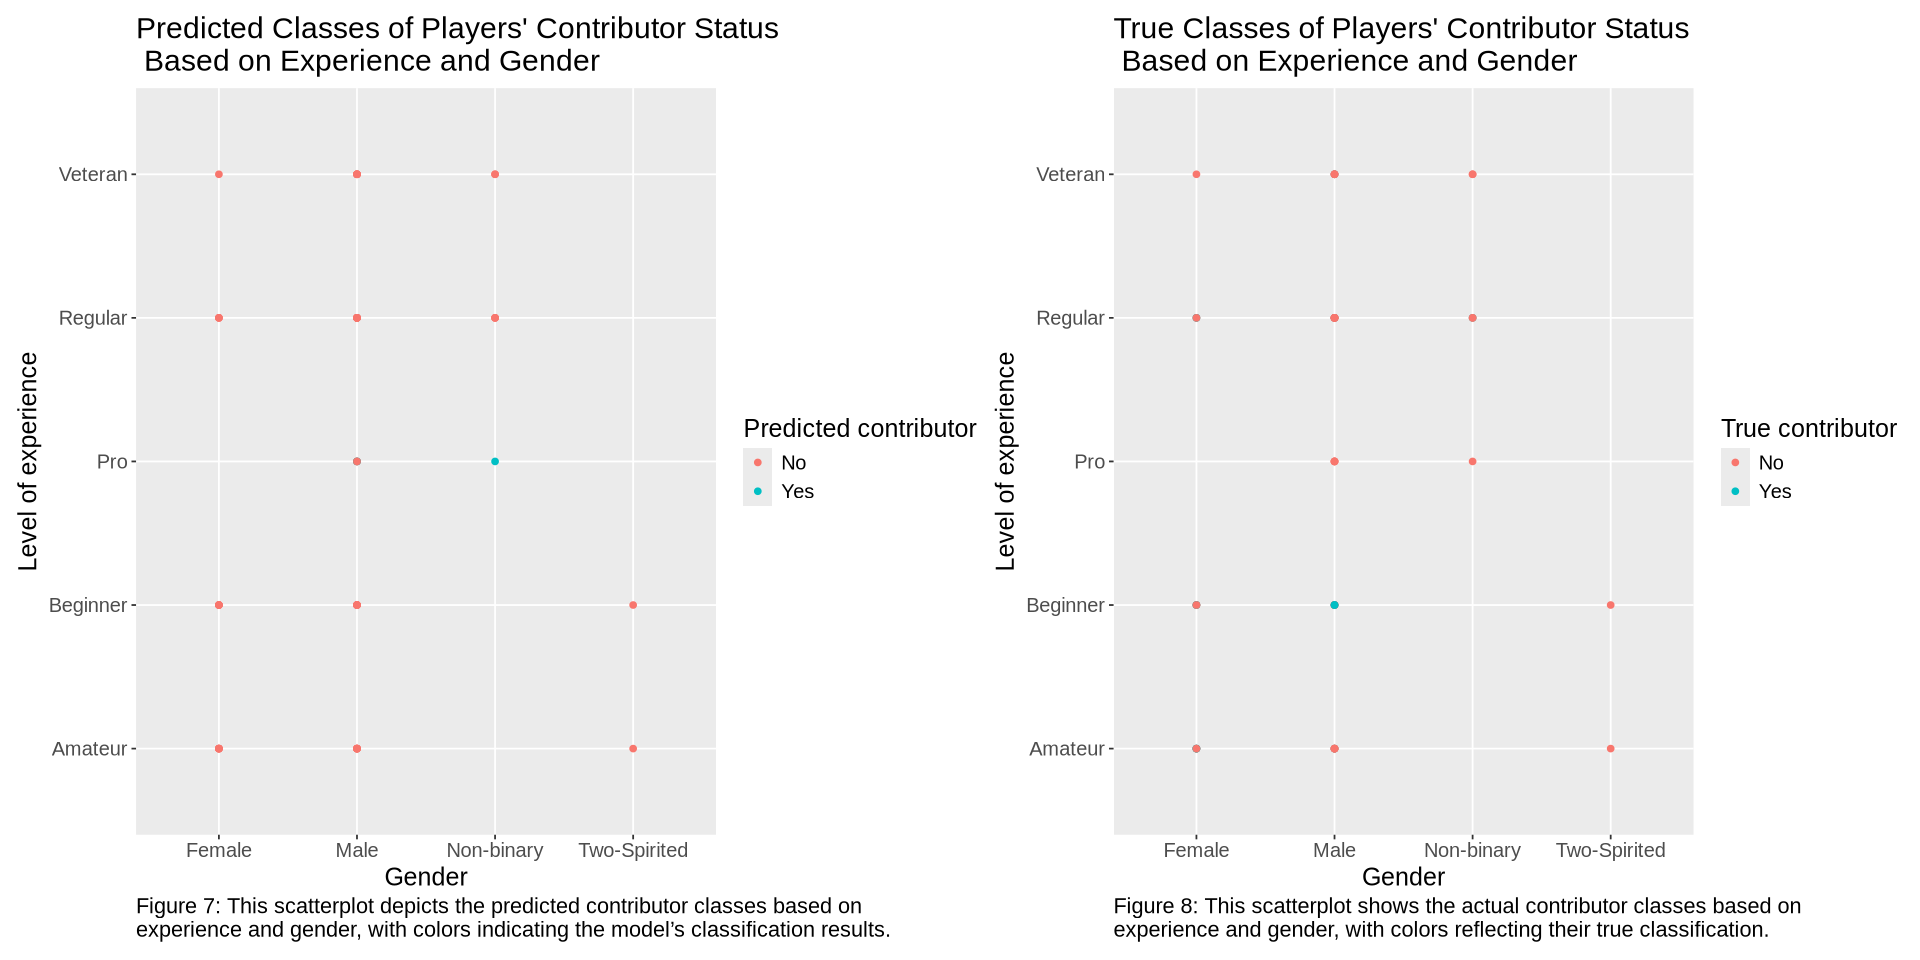

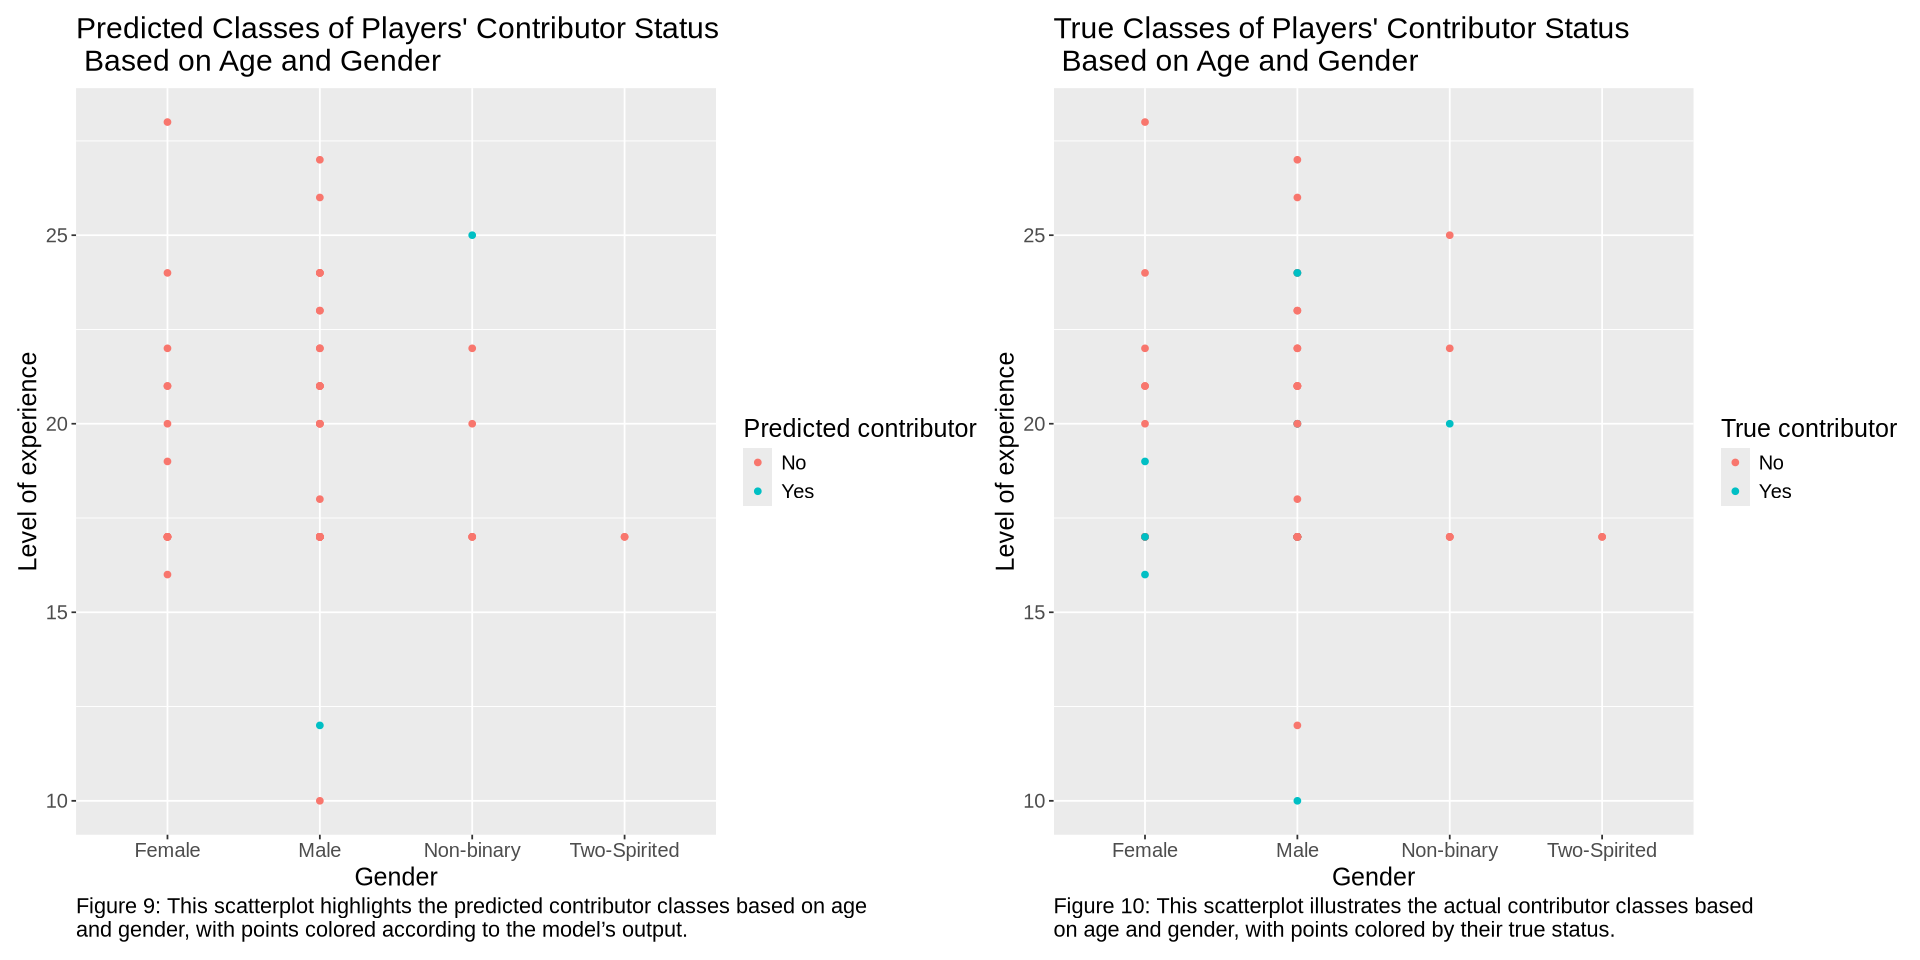

In [92]:
#Plotting the predictive analysis of the testing set

#Predictive plot of players' contributor status based on their experience and age
pred_plot_experience_vs_age <- test_predictions |>
    ggplot(aes(x=age, y=experience, color=.pred_class)) +
    geom_point() + 
    labs(x="Age",
         y="Level of experience",
         color="Predicted contributor",
         title="Predicted Classes of Players' Contributor status\n Based on Experience and Age",
         caption="Figure 5: This scatterplot visualizes the predicted contributor classes based on 
experience and age, with points colored according to the model's classification outputs.") +
    theme(text=element_text(size=15),
          plot.caption = element_text(hjust = 0, size = 13))

#True plot of players' contributor status based on their experience and age
true_plot_experience_vs_age <- test_predictions |>
    ggplot(aes(x=age, y=experience, color=contributor)) +
    geom_point() + 
    labs(x="Age",
         y="Level of experience",
         color="True contributor",
         title="True Classes  of Players' Contributor Status\n Based on Experience ane Age",
         caption="Figure 6: This scatterplot represents the actual contributor classes based on 
experience and age, with points colored by their true status.") +
    theme(text=element_text(size=15),
          plot.caption = element_text(hjust = 0, size = 13))

#Predictive plot of players' contributor status based on their experience and gender
pred_plot_experience_vs_gender <- test_predictions |>
    ggplot(aes(x=gender, y=experience, color=.pred_class)) +
    geom_point() + 
    labs(x="Gender",
         y="Level of experience",
         color="Predicted contributor",
         title="Predicted Classes of Players' Contributor Status\n Based on Experience and Gender",
         caption="Figure 7: This scatterplot depicts the predicted contributor classes based on 
experience and gender, with colors indicating the model’s classification results.") +
    theme(text=element_text(size=15),
          plot.caption = element_text(hjust = 0, size = 13))

#True plot of players' contributor status based on their experience and gender
true_plot_experience_vs_gender <- test_predictions |>
    ggplot(aes(x=gender, y=experience, color=contributor)) +
    geom_point() + 
    labs(x="Gender",
         y="Level of experience",
         color="True contributor",
         title="True Classes of Players' Contributor Status\n Based on Experience and Gender",
         caption="Figure 8: This scatterplot shows the actual contributor classes based on 
experience and gender, with colors reflecting their true classification. ") +
    theme(text=element_text(size=15),
          plot.caption = element_text(hjust = 0, size = 13))

#Predictive plot of players' contributor status based on their age and gender
pred_plot_age_vs_gender <- test_predictions |>
    ggplot(aes(x=gender, y=age, color=.pred_class)) +
    geom_point() + 
    labs(x="Gender",
         y="Level of experience",
         color="Predicted contributor",
         title="Predicted Classes of Players' Contributor Status\n Based on Age and Gender",
         caption="Figure 9: This scatterplot highlights the predicted contributor classes based on age 
and gender, with points colored according to the model’s output.") +
    theme(text=element_text(size=15),
          plot.caption = element_text(hjust = 0, size = 13))

#True plot of players' contributor status based on their age and gender
true_plot_age_vs_gender <- test_predictions |>
    ggplot(aes(x=gender, y=age, color=contributor)) +
    geom_point() + 
    labs(x="Gender",
         y="Level of experience",
         color="True contributor",
         title="True Classes of Players' Contributor Status\n Based on Age and Gender",
         caption="Figure 10: This scatterplot illustrates the actual contributor classes based 
on age and gender, with points colored by their true status.") +
    theme(text=element_text(size=15), 
          plot.caption = element_text(hjust = 0, size = 13))

#Display the predicted and true classes next to each other
options(repr.plot.width = 16, repr.plot.height = 8)
pred_plot_experience_vs_age | true_plot_experience_vs_age
pred_plot_experience_vs_gender | true_plot_experience_vs_gender
pred_plot_age_vs_gender | true_plot_age_vs_gender

## **Discussion**

In this study, we analyzed player data to examine the likelihood of contributing large amounts of data (one hour or more) based on factors like experience, gender, and age. The analysis revealed that experience did not strongly correlate with contribution levels. When we examine the proportion of contributions from players based on each experience type, we observe that the proportions fall within the range of 0.20 to 0.25. Although the overall proportions for each group are similar, it is important to consider subgroups. For instance, the "Amateur" subgroup has 64 observations in the dataset, while the "Pro" subgroup has only 14. In this case, we can be more confident in stating that "Amateur" players are more likely to contribute a larger amount of data compared to "Pro" players, due to the higher number of observations. This suggests that newer players may contribute more actively as part of their learning process, while more experienced players might not feel the need to contribute once they have achieved a certain level of proficiency. In addition, when we consider gender subgroups, we observe that 50% of "Agender" individuals contribute to the large data group, while the contribution proportions for "Male," "Female," "Non-binary," and "Prefer not to say" subcategories fall within the range of 0.20 to 0.27. It is worth noting that there were no contributors from the "Other" and "Two-spirited" gender subcategories. However, it is challenging to draw clear conclusions from these proportions because the data distribution across these subcategories is highly imbalanced. For instance, there are only 2 observations in the "Agender" subgroup, compared to 124 observations in the "Male" subgroup. As a result, any conclusions drawn from this visualization may be biased due to the under-representation of certain subgroups. Next on, the age analysis showed that most contributors fell within the adolescent age range of 13-23 years, but non-contributors showed more variation, with older individuals exhibiting outlier behaviours. This suggests that although younger players are more likely to contribute, age alone does not fully explain participation, and additional factors must be considered. 

The KNN model was trained using experience, gender, and age to classify players as contributors (played ≥1 hour) or non-contributors. We created side-by-side visualizations comparing the true class and the predicted class. These plots clearly demonstrate that the model performed well in classifying non-contributors, with most predictions aligning with the actual labels. To further evaluate the model, we calculated its precision, accuracy, and recall using the test dataset. These metrics provided a comprehensive understanding of the model’s strengths and limitations, particularly its strong ability to identify non-contributors while struggling with contributors. The model achieved an accuracy of 74%, with a precision of 0.771 and a recall of 0.949. The optimal value of k = 9 was selected through five-fold cross-validation, which showed the highest accuracy for this setting. The confusion matrix highlights that the model performs well at predicting non-contributors, with 37 true negatives and only 2 false positives. However, the model struggled with contributors, as indicated by 11 false negatives and 0 true positives. This discrepancy suggests that the dataset is imbalanced, with significantly fewer contributors compared to non-contributors, which likely biases the model toward predicting the majority class. 

The findings were surprising, particularly regarding experience. One might expect more experienced players—veterans or professionals—to contribute more, assuming they are more engaged. However, the data showed amateur players had the highest contribution rates, suggesting engagement is driven more by a desire to learn and explore than by perfecting skills. The gender results were as expected, with male and female players contributing at similar rates. Age analysis confirmed younger players contribute more often, but outliers in the non-contributor group indicate other factors besides age influence participation. This shows age alone can't explain who contributes, and further investigation of other player characteristics is needed. The KNN model performed as expected for an imbalanced dataset. While it identified non-contributors well, it struggled to classify contributors, being biased toward the majority class. The confusion matrix showed no true positives for contributors and many false negatives. Despite using multiple predictor variables, no clear correlation emerged between contributor status and experience, gender, or age. For instance, while 50% of Agender players were contributors, the small sample size (only 2 observations) means the result is not reliable. Similarly, experience levels showed no strong correlation with contribution, as amateurs contributed at rates similar to pros, regulars, and veterans. These results suggest the predictive model was ineffective at identifying contributors, as no strong trends related to experience, gender, or age were found. To improve, the platform should increase outreach to expand the sample size, which may reveal stronger trends and help the model better identify contributors. Future improvements could include adding more features, such as the number of sessions played or interest in gaming, and collecting more data from contributors to enhance the model’s predictive ability.

The findings have several important implications for platforms that rely on user-generated contributions. Understanding who is most likely to contribute can inform strategies to engage different player groups. For instance, the higher contribution rates among amateur players suggest that new users might be more motivated to engage as part of their learning process. Platforms could design tutorials for beginner challenges to encourage continued participation from these users. On the other hand, more experienced players may need different types of engagement, such as incentives or features that cater to their established goals. Gender inclusivity is another area where these findings could have an impact. The lower participation rates among non-binary players highlight the need for more inclusive features, such as customizable gender options or specific outreach efforts to non-binary players. Age-based insights also suggest that younger players are more likely to contribute, which could be useful for platforms targeting younger audiences. 

The findings of this study lead to several avenues for future research. One of the most pressing areas is understanding the motivations behind player contributions. The high contribution rates among amateur players suggest that there may be intrinsic factors driving participation, such as a desire to improve, gain recognition, or build social connections within the community. Future research could explore these motivations in more depth to help platforms tailor their engagement strategies to different player types. Another area for further investigation is improving model accuracy. Additionally, incorporating more features—such as player behaviour, in-game interactions, or social network dynamics—could provide a more nuanced understanding of who is likely to contribute. This could help create more effective models for predicting contributions and fostering engagement across different player groups.

## **References**

Basic recipes. • recipes. (n.d.). https://recipes.tidymodels.org/articles/Simple_Example.html

GeeksforGeeks. (2023, June 13). Box plot in R using ggplot2. GeeksforGeeks. https://www.geeksforgeeks.org/box-plot-in-r-using-ggplot2/